# Assignment 4. Moskalev Artem

## Sub-problem 1

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
mat_contents = sio.loadmat('task1.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

We are solving this task via linear least squares, so let's specify what $A$ and $b$ are:<br>
<br>
Firstly, $x,y$ given to us are in relative coordinate system, however we need to find absolute cordinates of positions and beacons. Let's fistly consider a case for only $x$ cordinates, $y$ can be expressed in the same way, so:<br>
<br>
$X_{beacon}^{abs}=X_{position}^{abs}+\Delta X_{beacon,position} + noise$, where $\Delta X_{beacon,position}$ is what we are given<br>
<br>
Thus, $\Delta X_{beacon,position} + noise = X_{beacon}^{abs}-X_{position}^{abs}$ is exactly what we want to minimize<br>
<br>
So, vector $b$ will hold all relative coordinates with noise, and $Ax$ should give us corresponding expressions in a form that we described above. It can be achieved if we will assign $x$ as vector consists of beacons and robot's position, and matrix $A$ will specify which of them to combine.<br>
Since we want to know absolute cordinates, we will also need to choose an origin for our estimation, I suggest that we just take the first position and forth beacon $(robots[0],beacons[0])$, hence we will also need to reflect it in the matrix $A$. For this, we just makes $X_{beacon}^{abs}$, corresponding to forth beacon, equals to $0$.<br>

##### Solve for x

In [2]:
size = np.unique(robots).shape[0] + np.unique(beacons).shape[0]

Let's take a glance, what our obsrvations of beacons look like

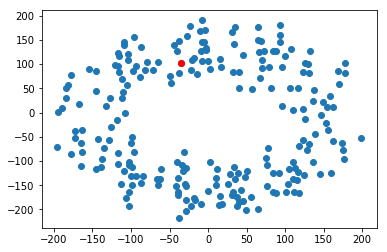

In [3]:
plt.scatter(x,y)
plt.scatter(x[0],y[0],color='r') #is the point, that will be our origin

In [4]:
B = x.copy() #our right-hand side

In [5]:
A = np.zeros((x.shape[0], size),dtype=np.float32)

In [6]:
for i in range(0,beacons.shape[0]):
    current_beacon=np.int(beacons[i])
    current_position=np.int(robots[i])
    if current_beacon==4: #origin, we switch to absolute cordinates
        A[i,current_beacon-1] = 0.
        A[i,(current_position+16)]=-1
    else:
        A[i,current_beacon-1] = 1.
        A[i,(current_position+16)]=-1.

In [7]:
true_x = np.linalg.lstsq(A,B)[0]
true_x[3]=0 #we took our forth beacon as an origin

##### Solve for y

Here the process is absolutely same, except we are taking given $y$ as our right-hand side.

In [8]:
B = y.copy()

In [9]:
true_y = np.linalg.lstsq(A,B)[0]
true_y[3]=0 #we took our forth beacon as an origin

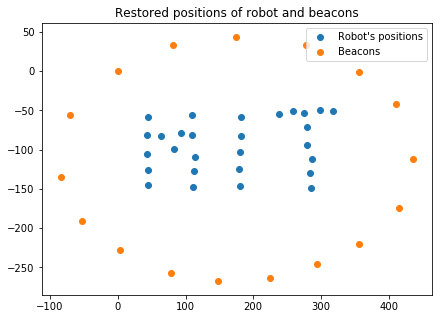

In [10]:
fig, ax = plt.subplots()
ax.scatter(true_x[17:],true_y[17:], label="Robot's positions")
ax.scatter(true_x[:17],true_y[:17],label='Beacons')
ax.set_title('Restored positions of robot and beacons')
legend = ax.legend()
fig.set_size_inches(7,5)
plt.show()

Let's wrap all this code in one function, so we can use it for any variables $robots,beacons,x,y$:

In [11]:
def least_squares_restoration(positions,beacons,x,y,plot=False):
    size = np.unique(robots).shape[0] + np.unique(beacons).shape[0]
    A = np.zeros((x.shape[0], size),dtype=np.float32)
    for i in range(0,beacons.shape[0]):
        current_beacon=np.int(beacons[i])
        current_position=np.int(robots[i])
        shift = np.unique(beacons).shape[0]-1
        origin = beacons[0][0]
        if current_beacon==origin:
            A[i,current_beacon-1] = 0.
            A[i,(current_position+shift)]=-1
        else:
            A[i,current_beacon-1] = 1.
            A[i,(current_position+shift)]=-1.
    B = x.copy()
    true_x = np.linalg.lstsq(A,B)[0]
    true_x[origin-1]=0
    B = y.copy()
    true_y = np.linalg.lstsq(A,B)[0]
    true_y[origin-1]=0
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(true_x[shift+1:],true_y[shift+1:], label="Robot's positions")
        ax.scatter(true_x[:shift+1],true_y[:shift+1],label='Beacons')
        ax.set_title('Restored positions of robot and beacons')
        legend = ax.legend()
        fig.set_size_inches(7,5)
        plt.show()
        return(true_x,true_y)
    else:
        return(true_x,true_y)

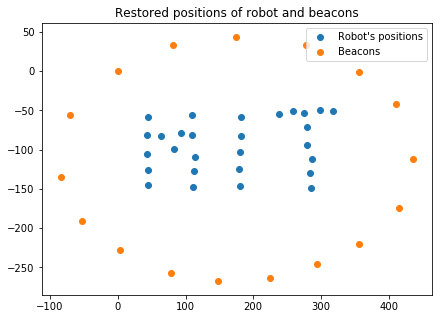

In [12]:
_,_= least_squares_restoration(robots, beacons,x,y,plot=True)

## Sub-problem 2

In [13]:
from scipy.optimize import least_squares

In [14]:
mat_contents = sio.loadmat('task2.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

Let's take a glance on the data, restoring it assuming that orientation is okay:

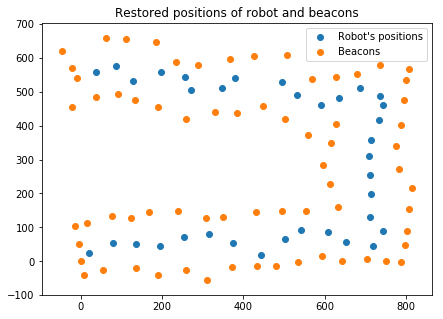

In [15]:
approx_x, approx_y = least_squares_restoration(robots, beacons,x,y,plot=True)

For restoring whole picture, we can apply the same logic as in Sub-problem 1, but also taking into account all the shifts caused by rotation, so let's consider the case for restoring x cordinates:<br>
<br>
$X_{i}^{abs}=X_{j}^{abs} + \Delta X_{i,j} + \Delta \hat{X}_{i,j}$, where $\Delta \hat{X}_{i,j}$ is a shift caused by rotation, $i \in I$ and $j \in J$ are sets of beacons and robot's positions respectively, so:<br>
<br>
$\Delta \hat{X}_{i,j} = \Delta X_i \cos(\theta_i) + \Delta Y_i \sin(\theta_i) - \Delta X_{i,j}$, hence $X_{i}^{abs}=X_{j}^{abs} + \Delta X_i \cos(\theta_i) + \Delta Y_i \sin(\theta_i)$<br>
Thus, the residual that we will want to minimize is $r_x=X_{j}^{abs} + \Delta X_i \cos(\theta_i) + \Delta Y_i \sin(\theta_i) -X_{i}^{abs}$ (for restoring $x's$ absolute cordinates).<br> 
Similarly for $y's$ absolute cordinates we can write a residual $r_y=Y_{j}^{abs} - \Delta X_i \sin(\theta_i) + \Delta Y_i \cos(\theta_i) -Y_{i}^{abs}$. But in general, we want to minimize them simultaneously and for that, we should minimize $r_x+r_y$.<br>
<br>
As for programming part of this task, I suggest using scipy.optimize, so let's write function of our residuals and functions that will return thier Jacobian, which in fact will have the following entries:

$\frac{\partial F_i}{\partial X_j^{abs}}=1$, $\frac{\partial F_i}{\partial Y_j^{abs}}=1$, $\frac{\partial F_i}{\partial X_i^{abs}}=-1$, $\frac{\partial F_i}{\partial Y_i^{abs}}=-1$, $\frac{\partial F_i}{\partial \theta_i}=-\Delta X_i \sin(\theta_i)+\Delta Y_i \cos(\theta_i) - \Delta X_i \cos(\theta_i) - \Delta Y_i \sin(\theta_i)$, which we, for simplification, will calculate separatelt for $x's$ and $y's$:

In [16]:
def func_Residuals(z, x, y):
    #z holds absolute cordinates of robot's position,
    #absolute cordinates of beacons and theta (angle of rotation)
    posN=np.unique(robots).shape[0]
    becN=np.unique(beacons).shape[0]
    obsN=robots.shape[0]
    residual_x = np.zeros(obsN)
    residual_y = np.zeros(obsN)
    
    x_pos_abs = z[:posN]
    y_pos_abs = z[posN:2*posN]
    x_bec_abs = z[2*posN:2*posN+becN]
    y_bec_abs = z[2*posN+becN:2*posN+2*becN]
    theta = z[2*posN+2*becN:]
    
    for i in range(obsN):
        current_beacon = beacons[i] - 1
        current_position = robots[i] - 1
        residual_x[i] = x_pos_abs[current_position]+x[i]*np.cos(theta[current_position])+y[i]*np.sin(theta[current_position])-x_bec_abs[current_beacon]
        residual_y[i]= y_pos_abs[current_position]-x[i]*np.sin(theta[current_position])+y[i]*np.cos(theta[current_position])-y_bec_abs[current_beacon]
    return np.concatenate((residual_x,residual_y))

In [17]:
def get_Jacobian(z, x, y):
    #z holds absolute cordinates of robot's position,
    #absolute cordinates of beacons and theta (angle of rotation)
    posN=np.unique(robots).shape[0]
    becN=np.unique(beacons).shape[0]
    obsN=robots.shape[0]
    
    Jaconian = np.zeros((2*obsN,3*posN + 2*becN))
    theta = z[2*(becN+posN):]
    for i in range(obsN):
        current_beacon= beacons[i]-1
        current_position= robots[i]-1
        Jaconian[i, current_position]= 1
        Jaconian[i+obsN, current_position+posN]= 1
        Jaconian[i, current_beacon+2*posN]= -1
        Jaconian[i+obsN, current_beacon+2*posN+becN]= -1
        Jaconian[i, current_position+2*(becN+posN)]= -x[i]*np.sin(theta[current_position])+ y[i]*np.cos(theta[current_position])
        Jaconian[obsN+i, current_position+2*(becN+posN)]= -x[i]*np.cos(theta[current_position]) -y[i]*np.sin(theta[current_position])
    return Jaconian

Let's firstly try to use the result we got from restoring positions with ordinary least squares as a initialization:

In [18]:
posN=np.unique(robots).shape[0]
becN=np.unique(beacons).shape[0]
obsN=robots.shape[0]

init_z = np.zeros(shape=(3*np.unique(robots).shape[0]+2*np.unique(beacons).shape[0]))
init_z[:posN] = approx_x[becN:].reshape(-1) #approx x_pos_abs
init_z[posN:2*posN] = approx_y[becN:].reshape(-1) #approx y_pos_abs
init_z[2*posN:2*posN+becN] = approx_x[:becN].reshape(-1) #approx x_bec_abs
init_z[2*posN+becN:2*posN+2*becN] = approx_y[:becN].reshape(-1) #approx y_bec_abs

In [19]:
restored = least_squares(fun=func_Residuals, x0=init_z, jac=get_Jacobian, args=(x,y))

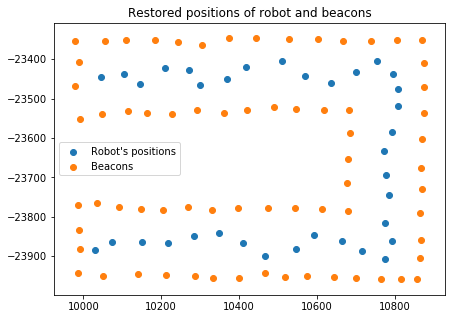

In [20]:
restored = restored.x

fig, ax = plt.subplots()
ax.scatter(restored[:posN],restored[posN:2*posN], label="Robot's positions")
ax.scatter(restored[2*posN:2*posN+becN],restored[2*posN+becN:2*posN+2*becN], label='Beacons')
ax.set_title('Restored positions of robot and beacons')
legend = ax.legend()
fig.set_size_inches(7,5)
plt.show()

Let's also try to assign some random initial vector

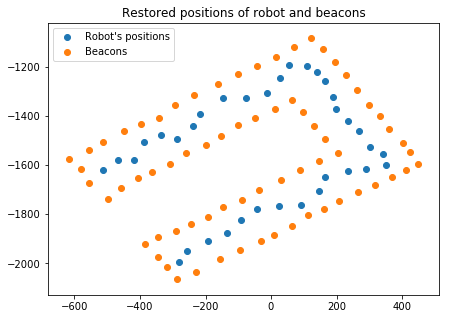

In [21]:
np.random.seed(1234)
init_z = np.random.normal(size=[3*np.unique(robots).shape[0]+2*np.unique(beacons).shape[0]])
restored = least_squares(fun=func_Residuals, x0=init_z, jac=get_Jacobian, args=(x,y))
restored = restored.x

fig, ax = plt.subplots()
ax.scatter(restored[:posN],restored[posN:2*posN], label="Robot's positions")
ax.scatter(restored[2*posN:2*posN+becN],restored[2*posN+becN:2*posN+2*becN], label='Beacons')
ax.set_title('Restored positions of robot and beacons')
legend = ax.legend()
fig.set_size_inches(7,5)
plt.show()

## Sub-problem 3

In [22]:
del mat_contents,beacons,robots,x,y,posN,becN,obsN,restored,init_z,approx_x, approx_y

In [51]:
from scipy.optimize import minimize
import time

mat_contents = sio.loadmat('task3.mat')
beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

posN,becN,obsN=np.unique(robots).shape[0],np.unique(beacons).shape[0],robots.shape[0]
thrs = 1.0

In [61]:
init_z = np.random.normal(size=[3*posN+2*becN])
restored = least_squares(func_Residuals, init_z, get_Jacobian, args=(x,y), method='lm')
z = restored.x #let's save it for as an initialization vector for our future optimization
#z_app = z.copy()

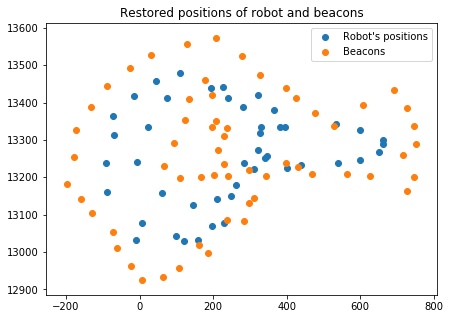

In [25]:
fig, ax = plt.subplots()
ax.scatter(z[:posN],z[posN:2*posN], label="Robot's positions")
ax.scatter(z[2*posN:2*posN+becN],z[2*posN+becN:2*posN+2*becN], label='Beacons')
ax.set_title('Restored positions of robot and beacons')
legend = ax.legend()
fig.set_size_inches(7,5)
plt.show()

In [26]:
#This solution seems far from optimal, so what we need to do is to add some robustness
del fig, ax

In [66]:
def get_Grad(z_vec,x,y):
    return (get_Jacobian(z_vec,x,y)).T@func_Residuals(z_vec,x,y)

def func_l(z_vec,x,y):
    return np.linalg.norm(func_Residuals(z_vec,x,y))

In [28]:
def func_r(z_vec, x, y):
    err = np.abs(func_Residuals(z_vec, x, y))
    
    err[err<thrs] = np.power(err[err < thrs],2)/ 2
    err[err>=thrs] = thrs*(err[err >= thrs] - thrs/2)
    return np.sum(err)

In [29]:
%time _ = minimize(fun=func_r, x0=z, args=(x,y), method='BFGS', options={'maxiter': 50})

CPU times: user 3min 39s, sys: 452 ms, total: 3min 40s
Wall time: 3min 30s


In [30]:
%time _ = minimize(fun=func_r, x0=z, args=(x,y), method='BFGS', options={'maxiter': 100})

CPU times: user 5min 35s, sys: 532 ms, total: 5min 35s
Wall time: 5min 15s


In [31]:
%time _ = minimize(fun=func_r, x0=z, args=(x,y), method='BFGS', options={'maxiter': 150})

CPU times: user 7min 28s, sys: 984 ms, total: 7min 29s
Wall time: 6min 58s


In [32]:
%time restored_ = minimize(fun=func_r, x0=z, args=(x,y), method='BFGS', options={'maxiter': 200})
z = restored_.x

CPU times: user 10min 30s, sys: 1.97 s, total: 10min 32s
Wall time: 9min 53s


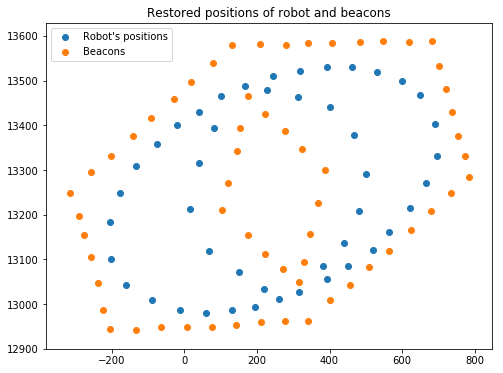

In [33]:
fig, ax = plt.subplots()
ax.scatter(z[:posN],z[posN:2*posN], label="Robot's positions")
ax.scatter(z[2*posN:2*posN+becN],z[2*posN+becN:2*posN+2*becN], label='Beacons')
ax.set_title('Restored positions of robot and beacons')
legend = ax.legend()
fig.set_size_inches(8,6)
plt.show()